Uczenie konwolucyjne:

In [1]:
try:
    import tensorflow_datasets as tfds
except Exception:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip","install", "tensorflow_datasets"])
    import tensorflow_datasets as tfds

In [2]:
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load("tf_flowers", split=['train[:10%]', "train[10%:25%]", "train[25%:]"], as_supervised=True, with_info=True)

class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

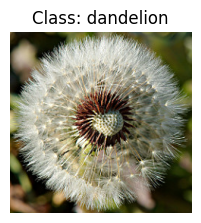

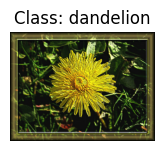

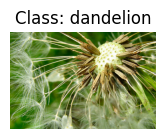

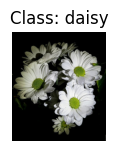

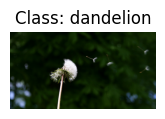

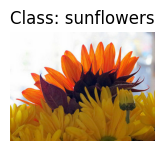

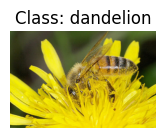

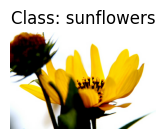

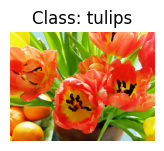

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    plt.show(block=False)

In [4]:
import tensorflow as tf 

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


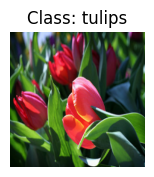

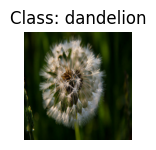

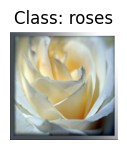

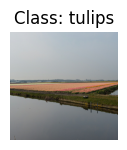

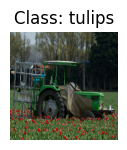

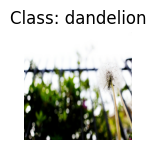

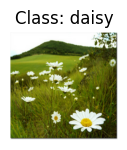

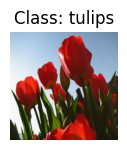

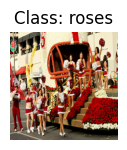

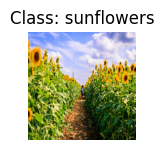

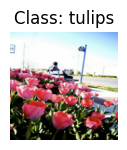

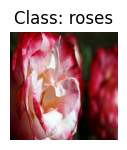

In [5]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
        plt.show()

In [6]:
import keras
from keras.models import Sequential

model = Sequential()

model.add(keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=7, strides=1, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=64, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=n_classes, activation="softmax"))

c:\Users\User\OneDrive\Dokumenty\Machine-Learning\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.2219 - loss: 1.6070 - val_accuracy: 0.4465 - val_loss: 1.4649
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.3334 - loss: 1.4976 - val_accuracy: 0.4574 - val_loss: 1.3837
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4020 - loss: 1.4111 - val_accuracy: 0.5245 - val_loss: 1.2557
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.4159 - loss: 1.3518 - val_accuracy: 0.5372 - val_loss: 1.1834
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.4480 - loss: 1.2915 - val_accuracy: 0.5808 - val_loss: 1.1138
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.4891 - loss: 1.2349 - val_accuracy: 0.5826 - val_loss: 1.1214
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.4980 - loss: 1.2055 - val_accuracy: 0.6189 - val_loss: 1.0638
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5431 - loss: 1.1520 - val_accuracy: 0.6588 - v

In [ ]:
acc_train = model.evaluate(train_set, verbose=0)[1]
acc_valid = model.evaluate(valid_set, verbose=0)[1]
acc_test = model.evaluate(test_set, verbose=0)[1]

import pickle
with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)

model.save('simple_cnn_flowers.keras')

In [9]:
print(acc_train, acc_valid, acc_test)

0.7231104373931885 0.6751360893249512 0.7411444187164307


Uczenie transferowe:

In [10]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [11]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [13]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1).repeat()
# for X_batch, y_batch in sample_batch:
#     for index in range(12):
#         plt.subplot(3, 4, index + 1)
#         plt.imshow(X_batch[index] / 2 + 0.5)
#         plt.title("Class: {}".format(class_names[y_batch[index]]))
#         plt.axis("off")
#         plt.show()

<Figure size 800x800 with 0 Axes>

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

from keras import layers

input = keras.Input(shape = (224, 224, 3))
base = base_model(input, training=False)
pooling = layers.GlobalAveragePooling2D()(base)
flatten = layers.Flatten()(pooling)
dense = layers.Dense(units=256, activation="relu")(flatten)
dropout = layers.Dropout(rate=0.5)(dense)
dense_2 = layers.Dense(units=64, activation="relu")(dropout)
dropout_2 = layers.Dropout(rate=0.5)(dense_2)
output = layers.Dense(units=n_classes, activation="softmax")(dropout_2)

model = keras.Model(inputs=input, outputs=output)

In [38]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.3607 - loss: 1.4804 - val_accuracy: 0.7405 - val_loss: 0.8202
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6365 - loss: 0.9466 - val_accuracy: 0.7913 - val_loss: 0.6067
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7103 - loss: 0.7623 - val_accuracy: 0.8076 - val_loss: 0.5215
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7907 - loss: 0.6154 - val_accuracy: 0.8258 - val_loss: 0.4803
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7952 - loss: 0.5608 - val_accuracy: 0.8385 - val_loss: 0.4517


In [39]:
for layer in base_model.layers:
    layer.trainable = True

model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8108 - loss: 0.5145 - val_accuracy: 0.8330 - val_loss: 0.4332
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8318 - loss: 0.4606 - val_accuracy: 0.8367 - val_loss: 0.4228
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8467 - loss: 0.4359 - val_accuracy: 0.8403 - val_loss: 0.4045
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8545 - loss: 0.4105 - val_accuracy: 0.8548 - val_loss: 0.3998
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8670 - loss: 0.3898 - val_accuracy: 0.8603 - val_loss: 0.3842


In [ ]:
acc_train = model.evaluate(train_set, verbose=0)[1]
acc_valid = model.evaluate(valid_set, verbose=0)[1]
acc_test = model.evaluate(test_set, verbose=0)[1]

import pickle
with open('xception_acc.pkl', 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)

model.save('xception_flowers.keras')

In [41]:
print(acc_train, acc_valid, acc_test)

[0.2343588024377823, 0.9244186282157898] [0.3842327892780304, 0.8602541089057922] [0.3650301396846771, 0.8692098259925842]
